In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
__file__ = 'InceptionResNetV2-Xception-8.29.1-0'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from keras import backend as K

def sign_sqrt(x):
    return K.sign(x) * K.sqrt(K.abs(x) + 1e-10)
 
def l2_norm(x):
    return K.l2_normalize(x, axis=-1)
 
def batch_dot(cnn_ab):
    return K.batch_dot(cnn_ab[0], cnn_ab[1], axes=[1, 1])

Using TensorFlow backend.


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras_applications.resnext import ResNeXt50
from keras.applications.nasnet import NASNetLarge
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
import PIL
import time

def preprocess_img(x):
    x = x / 127.5
    x -= 1.
    return x

In [5]:
path_data = '../garbage_classify/train_data'
batch_size = 8
img_size = 299
img_width = img_size
img_height = img_size
random_seed = 201908
path_data_train = '../tmp/data_train/'
path_data_valid = '../tmp/data_valid/'
labels_file = '../tmp/labels_raw.csv'

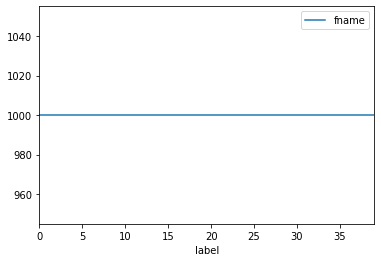

In [6]:
labels_train = pd.read_csv('../tmp/labels_train.csv')
labels_valid = pd.read_csv('../tmp/labels_valid.csv')
n_classess = labels_train.label.unique().shape[0]
labels_train.groupby(by='label').count().plot()

In [7]:
labels_train.label = labels_train.label.apply(lambda x: f'{x:02d}')
labels_valid.label = labels_valid.label.apply(lambda x: f'{x:02d}')
# labels_train['label_bin'].values = keras.utils.np_utils.to_categorical(
#     labels_train.label, n_classess)

In [8]:
ig = ImageDataGenerator(preprocessing_function=preprocess_img)

params_g = dict(
    batch_size=batch_size,
    # directory=path_data,
    # class_mode='other',
    x_col='fname',
    y_col='label',
    target_size=(img_width, img_height),
    interpolation='lanczos',
    seed=random_seed)

train_g = ig.flow_from_dataframe(
    labels_train, path_data_train, **params_g)
valid_g = ig.flow_from_dataframe(
    labels_valid, path_data_valid, **params_g)

Found 40000 validated image filenames belonging to 40 classes.
Found 2978 validated image filenames belonging to 40 classes.


In [9]:
input_tensor = Input((img_width, img_height, 3))

In [10]:
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model_Xception = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
for layer in base_model_InceptionResNetV2.layers:
    layer.name = 'InceptionResNetV2_'+layer.name
for layer in base_model_Xception.layers:
    layer.name = 'Xception_'+layer.name

In [12]:
# base_model_InceptionResNetV2_x = Reshape([model_resnet50.layers[-6].output_shape[1]*model_resnet50.layers[-6].output_shape[2],model_resnet50.layers[-6].output_shape[3]])(model_resnet50.layers[-6].output)
# base_model_Xception_x = Reshape([model_vgg16.layers[-1].output_shape[1]*model_vgg16.layers[-1].output_shape[2],model_vgg16.layers[-1].output_shape[3]])(model_vgg16.layers[-1].output)

cnn_dot_out = Lambda(batch_dot)([base_model_InceptionResNetV2.output,base_model_Xception.output])

# sign_sqrt_out = Lambda(sign_sqrt)(cnn_dot_out)
# l2_norm_out = Lambda(l2_norm)(sign_sqrt_out)
# flatten = Flatten()(l2_norm_out)
flatten = Flatten()(cnn_dot_out)

In [13]:
x = Dropout(0.3)(flatten)
predictions = Dense(n_classess, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Xception_InceptionResNetV2_inpu (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
InceptionResNetV2_conv2d_1 (Con (None, 149, 149, 32) 864         Xception_InceptionResNetV2_input_
__________________________________________________________________________________________________
Xception_conv2d_204 (Conv2D)    (None, 149, 149, 32) 864         Xception_InceptionResNetV2_input_
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 149, 149, 32) 96          InceptionResNetV2_conv2d_1[0

Xception_conv2d_275 (Conv2D)    (None, 35, 35, 64)   27648       Xception_activation_274[0][0]    
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 35, 35, 32)   96          InceptionResNetV2_conv2d_67[0][0]
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 35, 35, 32)   96          InceptionResNetV2_conv2d_69[0][0]
__________________________________________________________________________________________________
InceptionResNetV2_batch_normali (None, 35, 35, 64)   192         InceptionResNetV2_conv2d_72[0][0]
__________________________________________________________________________________________________
Xception_batch_normalization_27 (None, 35, 35, 32)   96          Xception_conv2d_270[0][0]        
__________________________________________________________________________________________________
Xception_b

Xception_activation_347 (Activa (None, 17, 17, 192)  0           Xception_batch_normalization_347[
__________________________________________________________________________________________________
InceptionResNetV2_block17_17_mi (None, 17, 17, 384)  0           InceptionResNetV2_activation_141[
                                                                 InceptionResNetV2_activation_144[
__________________________________________________________________________________________________
Xception_block17_17_mixed (Conc (None, 17, 17, 384)  0           Xception_activation_344[0][0]    
                                                                 Xception_activation_347[0][0]    
__________________________________________________________________________________________________
InceptionResNetV2_block17_17_co (None, 17, 17, 1088) 418880      InceptionResNetV2_block17_17_mixe
__________________________________________________________________________________________________
Xception_b

In [14]:
with open(f'../tmp/model_{__file__}.json','w') as f:
    model_json = model.to_json()
    f.write(model_json)

In [15]:
ckpt = ModelCheckpoint('../tmp/ckpt-'+__file__+'-Epoch_{epoch:03d}-acc_{acc:.5f}-val_acc_{val_acc:.5f}.h5', save_best_only=True, monitor='val_acc')

estop = EarlyStopping(monitor='val_acc', min_delta=1e-7,verbose=1, patience=20)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(
    train_g,
    # steps_per_epoch=100,
    steps_per_epoch=train_g.n // batch_size,
    epochs=100,
    callbacks=[ckpt, estop],
    validation_data=valid_g,
    # validation_steps=1,
    validation_steps=valid_g.n // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100


In [ ]:
!ls